# The Goal

## What're we doing?
We're going to let XGBoost, LightGBM and Catboost battle it out in 3 rounds:

- **Classification:** Classify images in the Fashion MNIST (60,000 rows, 784 features)

- **Regression:** Predict NYC Taxi fares (60,000 rows, 7 features)

- **Massive Dataset:** Predict NYC Taxi fares (2 million rows, 7 features)


## How're we doing it?
In each round here are the steps we'll follow:
1. Train baseline models of XGBoost, Catboost, LightGBM (trained using the same paramaters for each model)
2. Train fine-tuned models of XGBoost, Catboost, LightGBM using GridSearchCV
3. Measure performance on the following metrics:
    - training and prediction times
    - prediction score
    - interpretability (feature importance, shap values, visualize trees)

## What does this all mean?
A detailed analysis of the results can be found on my blog at: https://lavanya.ai/2019/06/27/battle-of-the-boosting-algorithms/

I hope you find this analysis useful, I would love to hear your feedback on improving it! I encourage you to fork this kernel, and play with the code.

If you like this kernel, please give it an upvote. Thank you!

# Setup

In [1]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from mlxtend.classifier import StackingCVClassifier
from mlxtend.regressor import StackingCVRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from dateutil import tz
from geopy import distance
import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

print(os.listdir("../input/"))

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


['nyctaxi', 'fashionmnist']


<Figure size 1600x800 with 0 Axes>

In [2]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [3]:
# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(rmse(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearch(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    if(type=='classification'):
        model = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    else:
        model = GridSearchCV(clf, params, scoring='r2', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(rmse(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [4]:
# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 7,5
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,6)]
    xlabs=[i for i in range(0,6)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

In [5]:
# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    # print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

# Round 1: Classification: Classify images in the Fashion MNIST

## A. Explore the Fashion MNIST dataset (60000 rows, 784 features)

In [6]:
# Read in dataset
fetch_from = '../input/fashionmnist/fashion-mnist_train.csv'
train = pd.read_csv(fetch_from)

fetch_from = '../input/fashionmnist/fashion-mnist_test.csv'
test = pd.read_csv(fetch_from)

In [7]:
# Perform train-test split
X_train, y_train, X_test, y_test = train.iloc[:,1:], train['label'], test.iloc[:,1:], test['label']
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pix

In [8]:
X_train.shape, X_test.shape
# Each image is 28*28(=784) pixels, hence the 784 features

((60000, 784), (10000, 784))

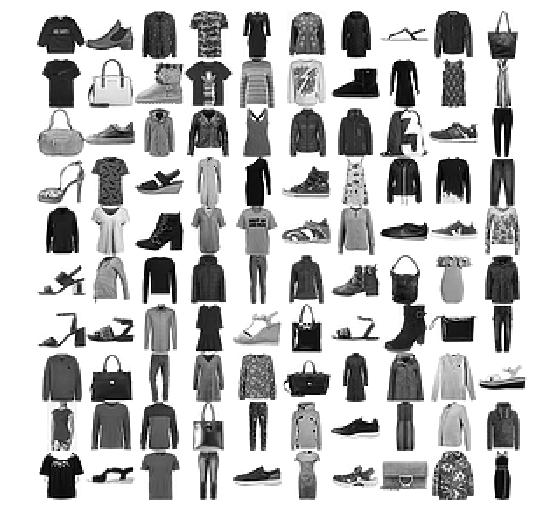

In [9]:
# Sample some images in the dataset
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
plt.figure(figsize=(9,9))
example_images = X_train[:100]
plot_digits(example_images.values, images_per_row=10)
plt.show()

## B. Baseline models

In [10]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

### XGBoost

In [11]:
xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:14:08

Prediction time: 
Execution Time: 00:00:01


### LightGBM

In [12]:
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:02:33

Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [13]:
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=6), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:04:39

Prediction time: 
Execution Time: 00:00:01


## C. Fine-tuned models

### XGBoost

In [14]:
# XGBoost with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
xgboost_gs = GridSearch(XGBClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 01:02:34
Prediction time: 
Execution Time: 00:00:01


### LightGBM

In [15]:
# LightGBM with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
lgb_gs = GridSearch(LGBMClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 00:32:25
Prediction time: 
Execution Time: 00:00:01


### CatBoost

In [16]:
# CatBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}]
cat_gs = GridSearch(CatBoostClassifier(random_state=42, silent = True,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 00:23:29
Prediction time: 
Execution Time: 00:00:01


## D. The Results

In [17]:
# free up memory be deleting dataframes no longer needed
del [[y_train, X_test, y_test, train, test]]

In [18]:
models = [('XGBoost', xgboost),
         ('LightGBM', lgb),
         ('CatBoost', cat),
         ('XGBoost GridSearch', xgboost_gs),
         ('LightGBM GridSearch', lgb_gs),
         ('CatBoost GridSearch', cat_gs)]

### Accuracy Scores

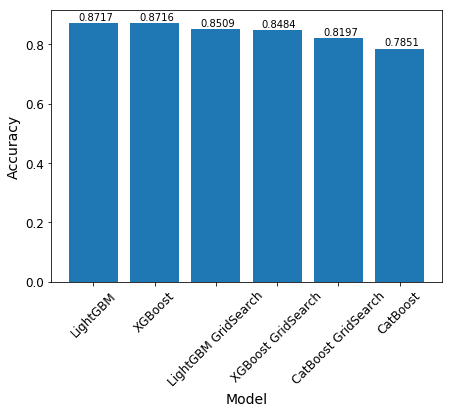

In [19]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

### Training and Prediction Times

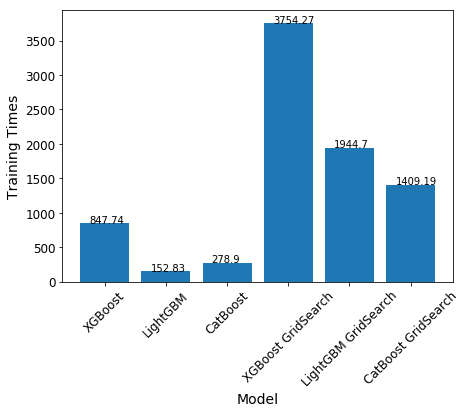

In [20]:
training_times = [round(time,2) for time in training_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Training Times': training_times })
plot_metric(model_train_times, score='Training Times')

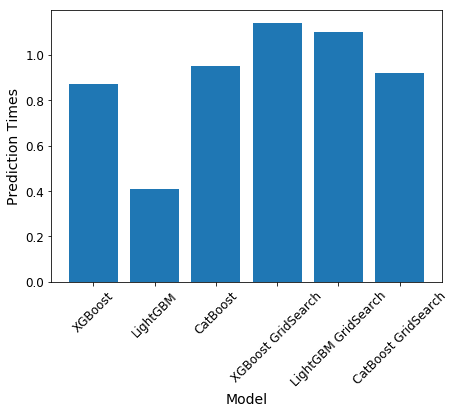

In [21]:
prediction_times = [round(time,2) for time in prediction_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Prediction Times': prediction_times })
plot_metric(model_train_times, score='Prediction Times')

### Interpretability

A model's prediction score only paints a partial picture of its predictions. We also want to know *why* the model is making its predictions.

Here we plot the model's feature importances, SHAP values and draw an actual decision tree to get a firmer understanding of the model's predictions.

#### Feature Importances

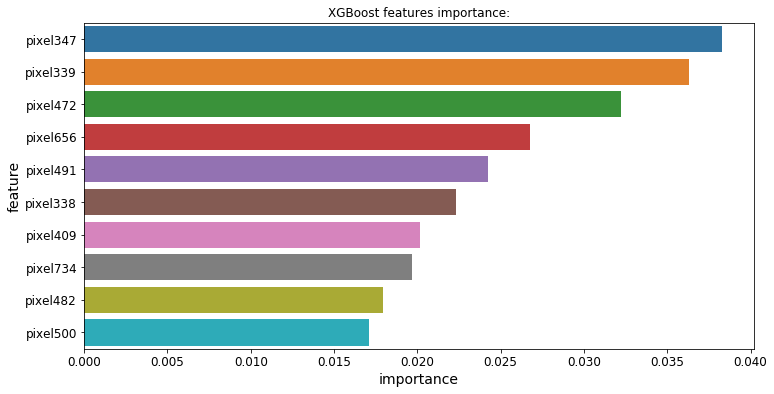

In [22]:
# XGBoost
feature_importances(X_train, xgboost, 'XGBoost')

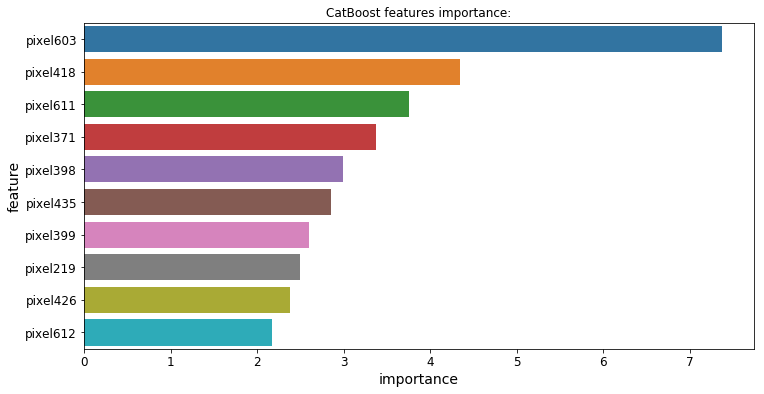

In [23]:
# CatBoost
feature_importances(X_train, cat, 'CatBoost')

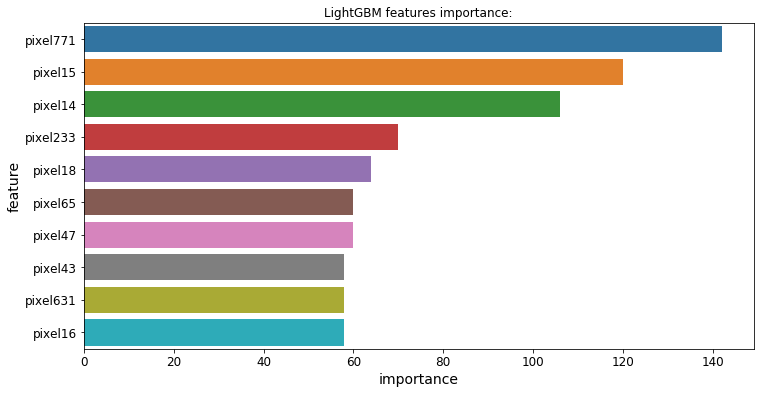

In [24]:
# LightGBM
feature_importances(X_train, lgb, 'LightGBM')

#### SHAP Values

Reference table for understanding which class names the class indexes refer to in the graphs below:

| Class | Name |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

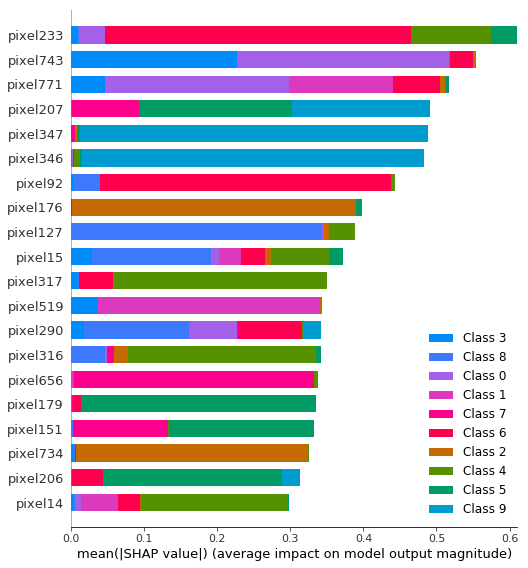

In [25]:
# XGBoost
shap_values(X_train.iloc[:500,:], xgboost, 'XGBoost')

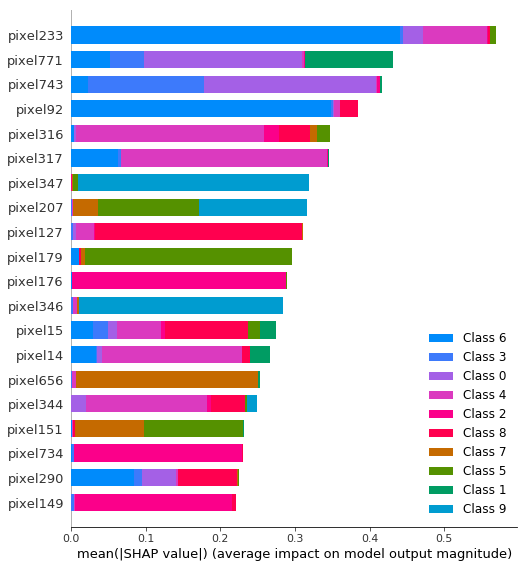

In [26]:
# LightGBM
shap_values(X_train.iloc[:500,:], lgb, 'LightGBM')

**CatBoost**
CatBoost doesn't work out of the box with shap_values() and results in the kernel crashing.

#### Visualize Trees

In [27]:
# Set figure size for decision tree plots
rcParams['figure.figsize'] = 80,50

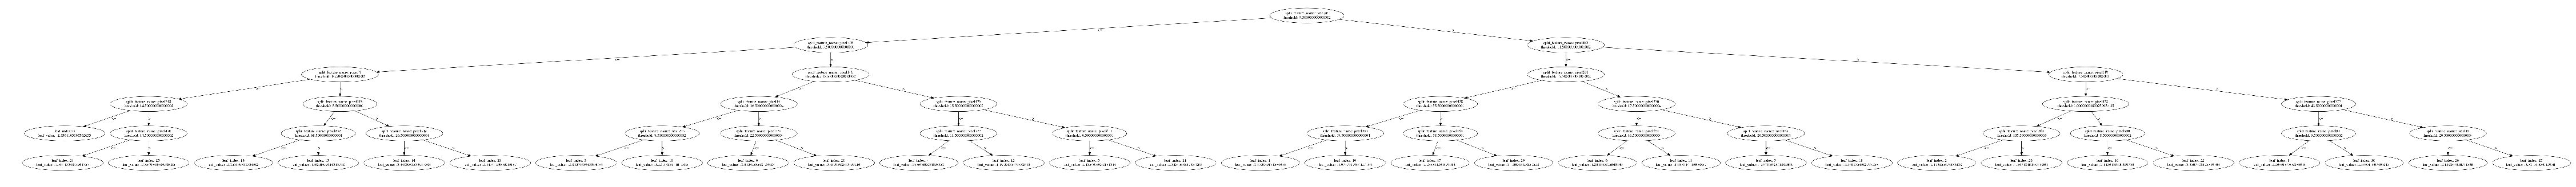

In [28]:
# LightGBM
lightgbm.plot_tree(lgb);

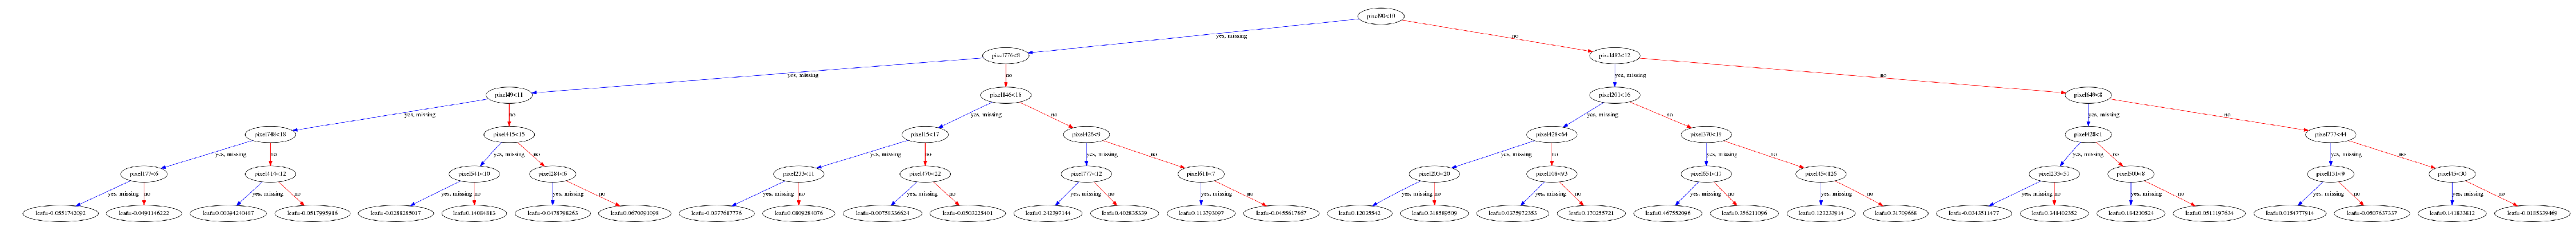

In [29]:
# XGBoost
xgb.plot_tree(xgboost);

**CatBoost**

CatBoost ships with no plotting function for its trees. If you really need to visualize CatBoost results, a work-around is proposed here: https://blog.csdn.net/l_xzmy/article/details/81532281

In [30]:
# Clear memory before moving onto the next round
import gc
gc.collect()

18498

In [31]:
del [[X_train]]

# Round 2: Regression on a medium Dataset: Predict NYC Taxi fares

## A. Explore the NYC Taxi dataset (60,000 rows, 6 features)

In [32]:
# Get data from New York City Taxi Fare Prediction
n = 60000
train = pd.read_csv('../input/nyctaxi/train.csv', nrows=n)
test = pd.read_csv('../input/nyctaxi/test.csv')
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [33]:
train.shape

(60000, 7)

In [34]:
test.shape

(2001, 7)

In [35]:
# Feature Engineering
# this cell was adapted from https://www.kaggle.com/mahtieu/nyc-taxi-fare-prediction-data-expl-xgboost
def feature_engineering(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    #Drop rows with null values
    df = df.dropna(how = 'any', axis = 'rows')
    #Free rides, negative fares and passenger count filtering
    df = df[df.eval('(fare_amount > 0) & (passenger_count <= 6)')]
    # Coordinates filtering - Pickup and dropoff locations should be within the limits of NYC
    df = df[(df.pickup_longitude >= -77) &
                  (df.pickup_longitude <= -70) &
                  (df.dropoff_longitude >= -77) &
                  (df.dropoff_longitude <= 70) &
                  (df.pickup_latitude >= 35) &
                  (df.pickup_latitude <= 45) &
                  (df.dropoff_latitude >= 35) &
                  (df.dropoff_latitude <= 45)]

    df.pickup_datetime = df.pickup_datetime.dt.tz_localize('UTC')
    df.pickup_datetime = df.pickup_datetime.dt.tz_convert(tz.gettz('America/New_York'))

    # Fares may change every year
    df['year'] = df.pickup_datetime.dt.year

    # Different fares during weekdays and weekends
    df['dayofweek'] = df.pickup_datetime.dt.dayofweek

    # Different fares during public holidays
    df['dayofyear'] = df.pickup_datetime.dt.dayofyear

    # Different fares in peak periods and off-peak periods
    df['hourofday'] = df.pickup_datetime.dt.hour

    df = df.drop('pickup_datetime', axis=1)

    # Computes the distance (in miles) between the pickup and the dropoff locations
    df['distance'] = df.apply(
        lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (x.dropoff_latitude, x.dropoff_longitude)).miles,
        axis = 1)

    df = df[df.eval('(distance > 0) & (distance < 150)')]
    fare_distance_ratio = (df.fare_amount/df.distance)
    fare_distance_ratio.describe()

    (fare_distance_ratio[fare_distance_ratio < 45]).hist()

    # Drop incoherent fares
    df = df[fare_distance_ratio < 45]
    del fare_distance_ratio

    # Coordinates of the 3 airpots of NYC
    airports = {'jfk': [40.6441666, -73.7822222],
                'laguardia': [40.7747222, -73.8719444],
                'newark': [40.6897222, -74.175]}

    # Computes the distance between the pickup location and the airport
    pickup = df.apply(lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (airports.get('jfk'))).miles, axis=1)
    # Computes the distance between the dropoff location and the airport
    dropoff = df.apply(lambda x: distance.distance((x.dropoff_latitude, x.dropoff_longitude), (airports.get('jfk'))).miles, axis=1)
    # Selects the shortest distance
    df['to_jfk'] = pd.concat((pickup, dropoff), axis=1).min(axis=1)

    pickup = df.apply(lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (airports.get('laguardia'))).miles, axis=1)
    dropoff = df.apply(lambda x: distance.distance((x.dropoff_latitude, x.dropoff_longitude), (airports.get('laguardia'))).miles, axis=1)
    df['to_laguardia'] = pd.concat((pickup, dropoff), axis=1).min(axis=1)

    pickup = df.apply(lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (airports.get('newark'))).miles, axis=1)
    dropoff = df.apply(lambda x: distance.distance((x.dropoff_latitude, x.dropoff_longitude), (airports.get('newark'))).miles, axis=1)
    df['to_newark'] = pd.concat((pickup, dropoff), axis=1).min(axis=1)
    del pickup, dropoff
    return df

def remove_sparse(df):
    features = [x for x in df.columns]
    for feature in features:
        if len(np.unique(df[feature]))<2:
            df.drop(feature, axis=1, inplace=True)
    return df

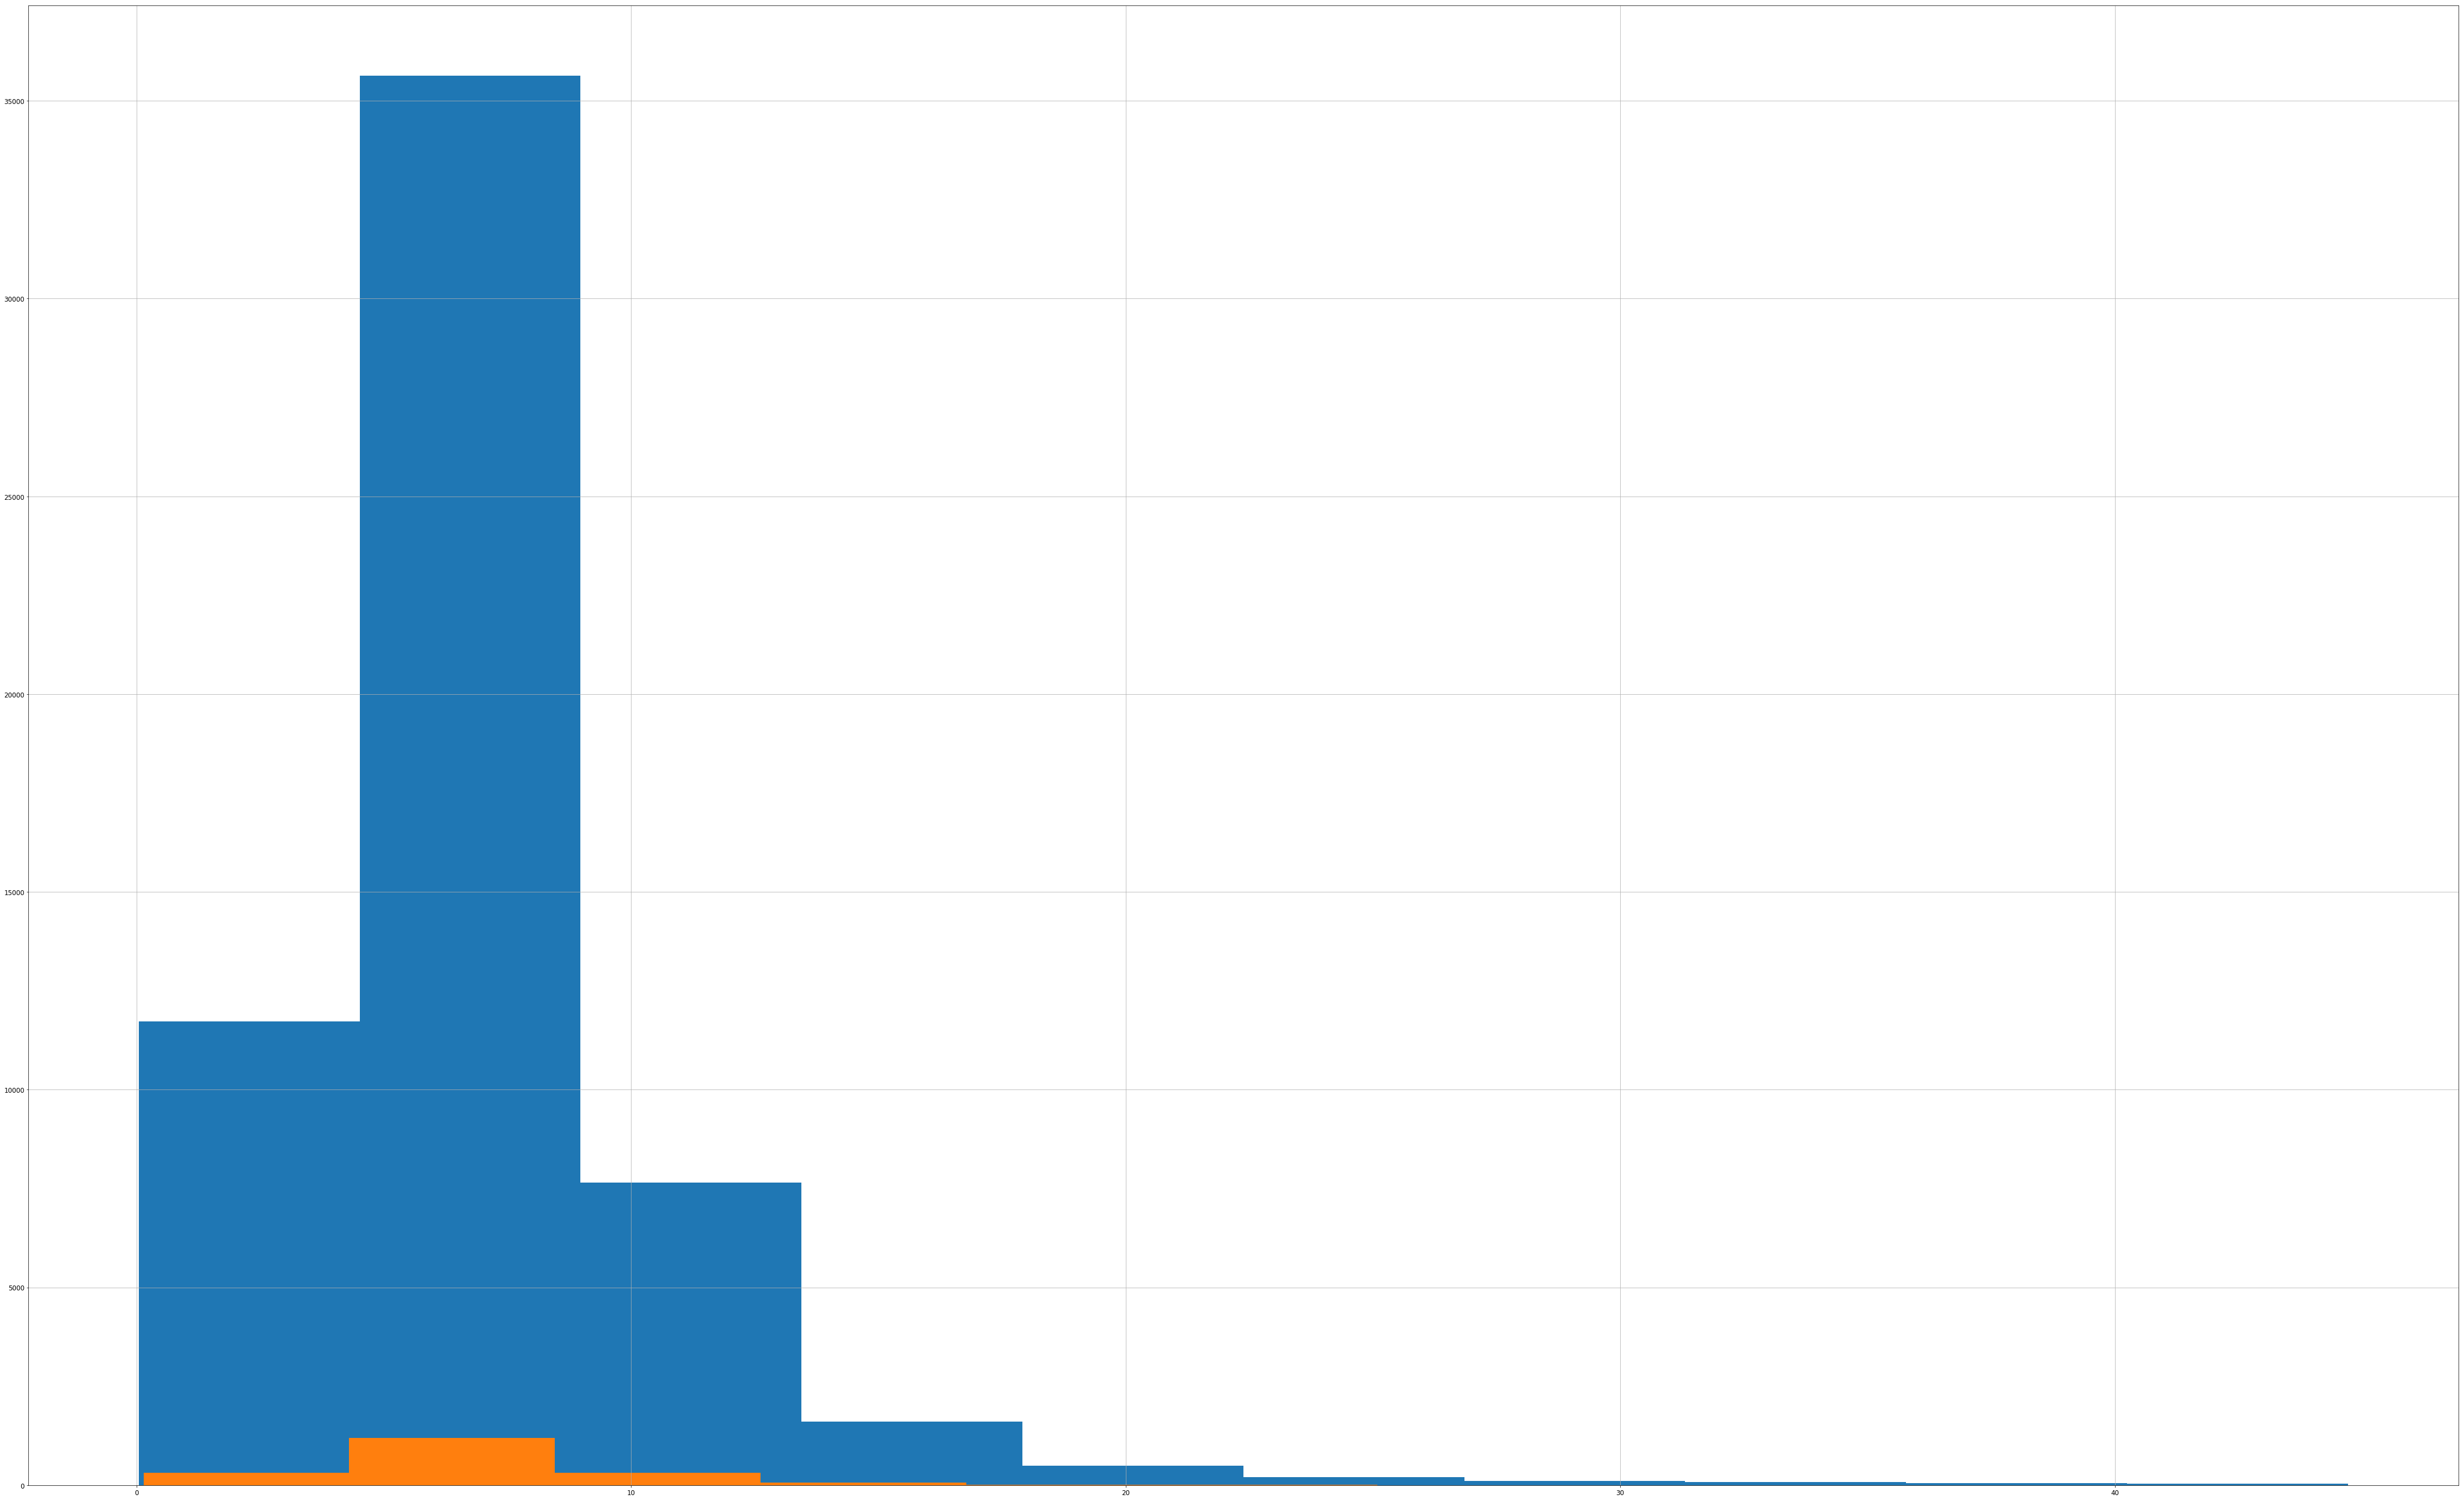

In [36]:
train = remove_sparse(train)
test = remove_sparse(test)
train = feature_engineering(train)
test = feature_engineering(test)
y_train = train.fare_amount
X_train = train.drop('fare_amount', axis=1)
y_test = test.fare_amount
X_test = test.drop('fare_amount', axis=1)

In [37]:
X_train.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,dayofweek,dayofyear,hourofday,distance,to_jfk,to_laguardia,to_newark
0,-73.844311,40.721319,-73.841610,40.712278,1,2009,0,166,13,0.639764,5.641042,3.960033,17.501190
1,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,11,5.246511,13.128071,5.651922,8.479163
2,-73.982738,40.761270,-73.991242,40.750562,2,2011,2,229,20,0.863167,13.205934,5.886113,10.521077
3,-73.987130,40.733143,-73.991567,40.758092,1,2012,5,112,0,1.737223,12.390673,6.379848,10.309372
4,-73.968095,40.768008,-73.956655,40.783762,1,2010,1,68,2,1.241710,12.972516,4.486914,12.130230


In [38]:
X_test.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,dayofweek,dayofyear,hourofday,distance,to_jfk,to_laguardia,to_newark
0,-73.955140,40.779382,-73.914775,40.820602,2,2010,5,16,10,3.545447,13.018637,3.881634,13.093870
1,-73.998130,40.740360,-74.004150,40.733418,2,2010,2,48,23,0.573840,13.139567,7.032753,9.463861
2,-74.002960,40.739107,-73.990593,40.746082,2,2012,3,145,11,0.808024,13.008234,6.531418,9.654219
3,-73.985075,40.754526,-74.007655,40.746556,1,2013,1,239,6,1.306309,13.094860,6.096775,9.621335
4,-73.991698,40.759568,-73.996223,40.753263,5,2012,5,322,8,0.495634,13.526801,6.369029,10.359148


## B. Baseline models

In [39]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

In [40]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### XGBoost

In [41]:
# XGBoost
xgboost = Train(XGBRegressor(n_estimators=50,
                        max_depth = 9,
                        boosting_type = 'gbdt',
                        learning_rate = 0.05,
                        subsample = 0.85,
                        colsample_bytree = 0.85,
                        reg_alpha = 1e-4,
                        silent = True,
                        n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:06

Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [42]:
# LightGBM
lgb = Train(LGBMRegressor(n_estimators=50,
                    max_depth = 9,
                    boosting_type = 'gbdt',
                    learning_rate = 0.05,
                    subsample = 0.85,
                    colsample_bytree = 0.85,
                    reg_alpha = 1e-4,
                    silent = True,
                    n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:01

Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [43]:
# Catboost
cat = Train(CatBoostRegressor(n_estimators=50,
                        max_depth = 9,
                        loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        learning_rate = 0.05,
                        boosting_type = 'Plain',
                        bootstrap_type = 'Bernoulli',
                        subsample = 0.85,
                        silent = True), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:02

Prediction time: 
Execution Time: 00:00:00


## C. Fine-tuned models

### XGBoost

In [44]:
# XGBoost with GridSearch
param_grid = [{'n_estimators': [10,100],
               'max_depth': [5, 10],
               'colsample_bytree': [0.8, 0.9],
               'learning_rate': [0.05, 0.1],
               'boosting_type': ['gbdt'],
               'reg_alpha': [1e-4]
               }]
xgboost_gs = GridSearch(XGBRegressor(), param_grid, X_train[:4000], y_train[:4000], X_test, y_test, type='reg')

[02:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training time: 
Execution Time: 00:00:25
Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [45]:
# LightGBM with GridSearch
param_grid = [{'n_estimators': [10,100],
               'max_depth': [5, 10],
               'colsample_bytree': [0.8, 0.9],
               'learning_rate': [0.05, 0.01],
               'boosting_type': ['gbdt'],
               'reg_alpha': [1e-4]
               }]
lgb_gs = GridSearch(LGBMRegressor(), param_grid, X_train[:4000], y_train[:4000], X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:07
Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [46]:
# CatBoost with GridSearch
param_grid = [{'n_estimators': [10,100],
               'learning_rate': [0.05, 0.01],
               'subsample': [0.8, 0.9]
               }]
cat_gs = GridSearch(CatBoostRegressor(loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        boosting_type = 'Plain',
                        bootstrap_type = 'Bernoulli',
                        silent = True), param_grid, X_train[:4000], y_train[:4000], X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:10
Prediction time: 
Execution Time: 00:00:00


## D. The Results

In [47]:
models = [('XGBoost', xgboost),
         ('LightGBM', lgb),
         ('CatBoost', cat),
         ('XGBoost GridSearch', xgboost_gs),
         ('LightGBM GridSearch', lgb_gs),
         ('CatBoost GridSearch', cat_gs)]

### R2 Scores

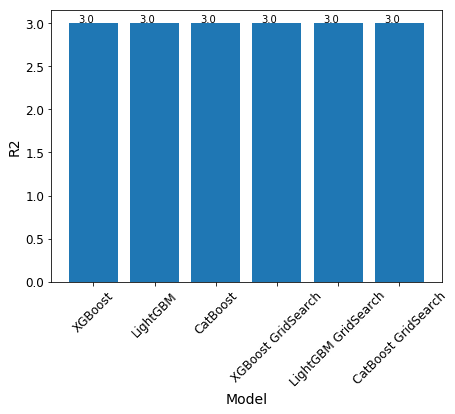

In [48]:
scores = [round(score) for score in scores]
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'R2': scores })
model_scores.sort_values(by='R2',ascending=False,inplace=True)
plot_metric(model_scores, score='R2')

### Training and Prediction Times

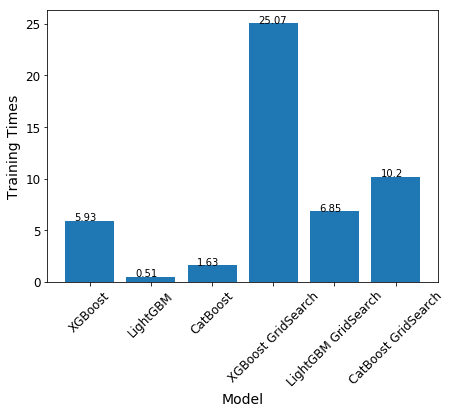

In [49]:
training_times = [round(time,2) for time in training_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Training Times': training_times })
plot_metric(model_train_times, score='Training Times')

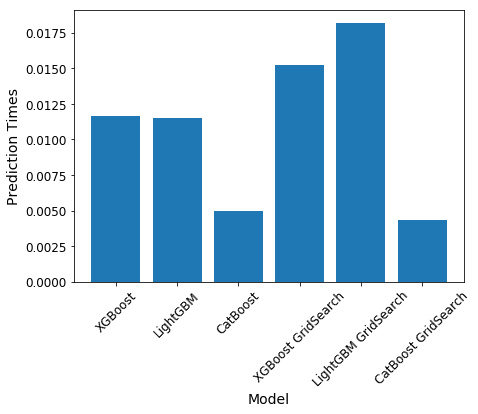

In [50]:
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Prediction Times': prediction_times })
plot_metric(model_train_times, score='Prediction Times')

### Interpretability

A model's prediction score only paints a partial picture of its predictions. We also want to know *why* the model is making its predictions.

Here we plot the model's feature importances, SHAP values and draw an actual decision tree to get a firmer understanding of the model's predictions.

#### Feature Importances

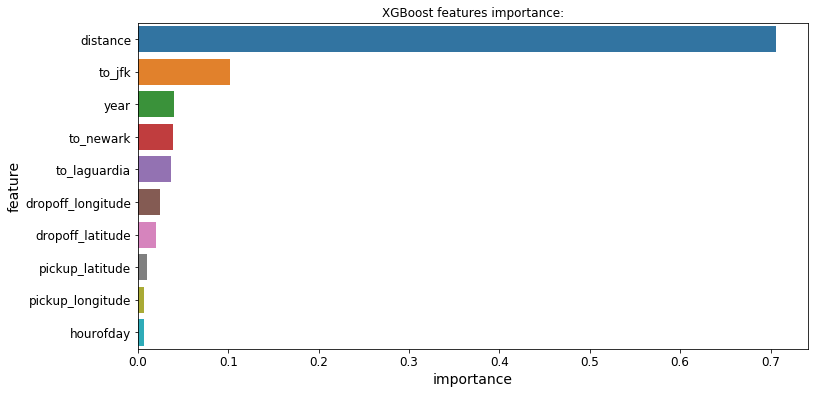

In [51]:
# XGBoost
feature_importances(X_train, xgboost, 'XGBoost')

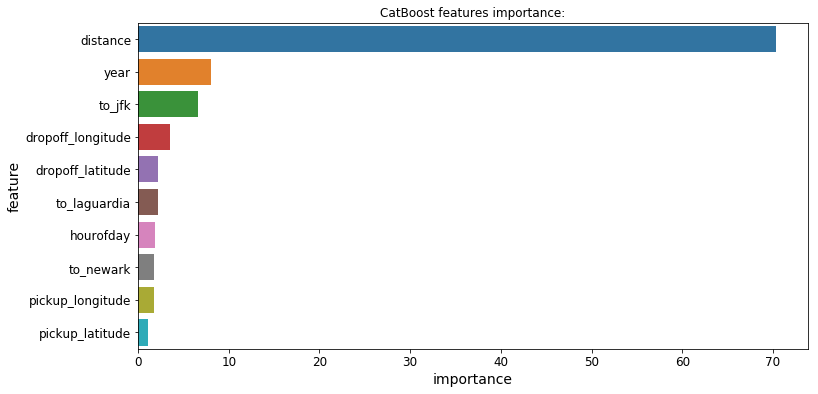

In [52]:
# CatBoost
feature_importances(X_train, cat, 'CatBoost')

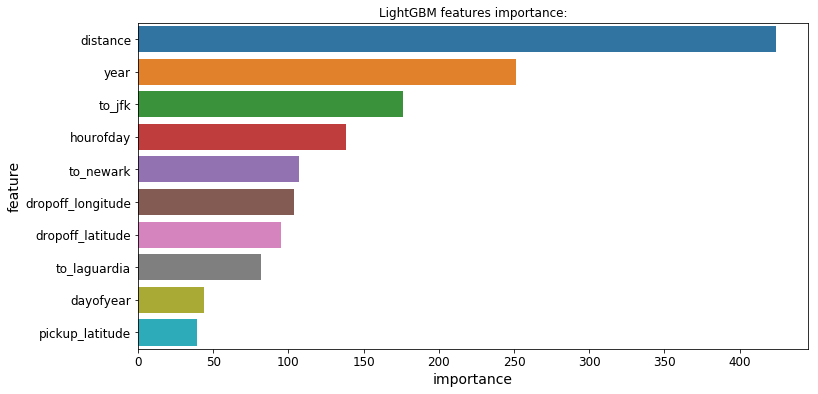

In [53]:
# LightGBM
feature_importances(X_train, lgb, 'LightGBM')

#### SHAP Values

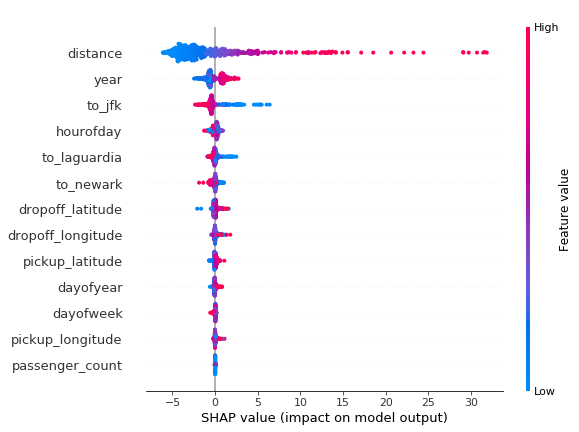

In [54]:
# XGBoost
shap_values(X_train.iloc[:500,:], xgboost, 'XGBoost')

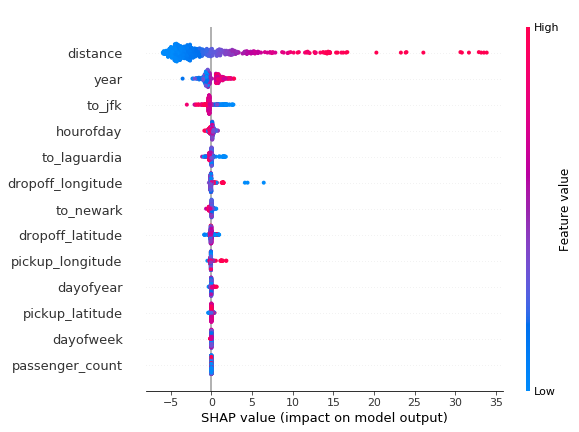

In [55]:
# LightGBM
shap_values(X_train.iloc[:500,:], lgb, 'LightGBM')

**CatBoost**
CatBoost doesn't work out of the box with shap_values() and results in the kernel crashing.

#### Visualize Trees

In [56]:
# Set figure size for decision tree plots
rcParams['figure.figsize'] = 80,50

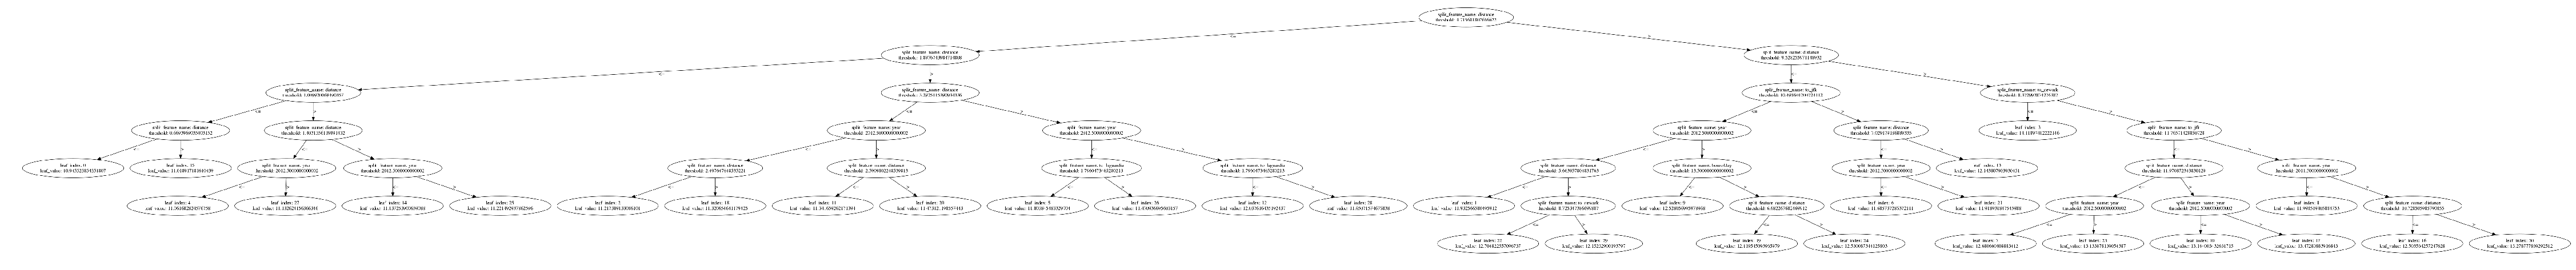

In [57]:
# LightGBM
lightgbm.plot_tree(lgb);

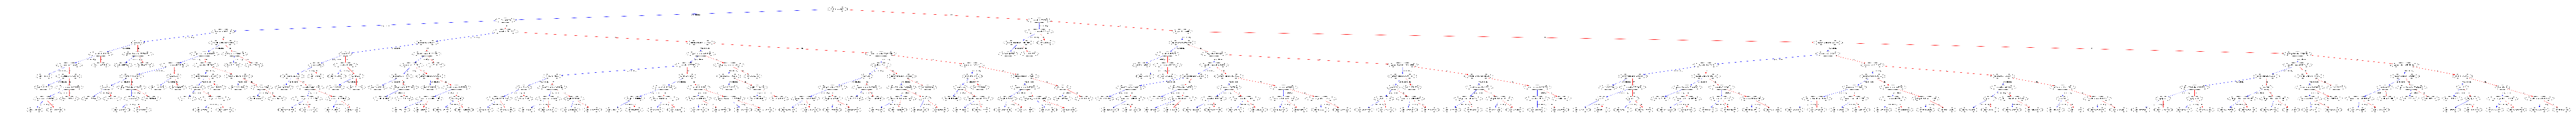

In [58]:
# XGBoost
xgb.plot_tree(xgboost);

**CatBoost**

CatBoost ships with no plotting function for its trees. If you really need to visualize CatBoost results, a work-around is proposed here: https://blog.csdn.net/l_xzmy/article/details/81532281

In [59]:
# Clear memory before moving onto the next round
import gc
gc.collect()

36689

# Round 3: Regression on a massive Dataset: Predict NYC Taxi fares (2 million rows, 7 features)

## NYC Taxi dataset (2 million rows, 6 features)

We're using the same dataset as above, but this time instead of training on 60,000 rows, we're going to train the models on 2 million rows and see if they're up to the challenge!

In [60]:
# Get data from New York City Taxi Fare Prediction
# allocate 1000 rows for test set, the rest for training set
n=2000000
train = pd.read_csv('../input/nyctaxi/train_20mil.csv', nrows=n)
test = pd.read_csv('../input/nyctaxi/train_20mil.csv', skiprows=n)
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [61]:
train.shape, test.shape

((2000000, 7), (18000000, 7))

## A. Baseline models

In [62]:
prediction_times = []
training_times = []
scores = []

KeyError: 'pickup_datetime'

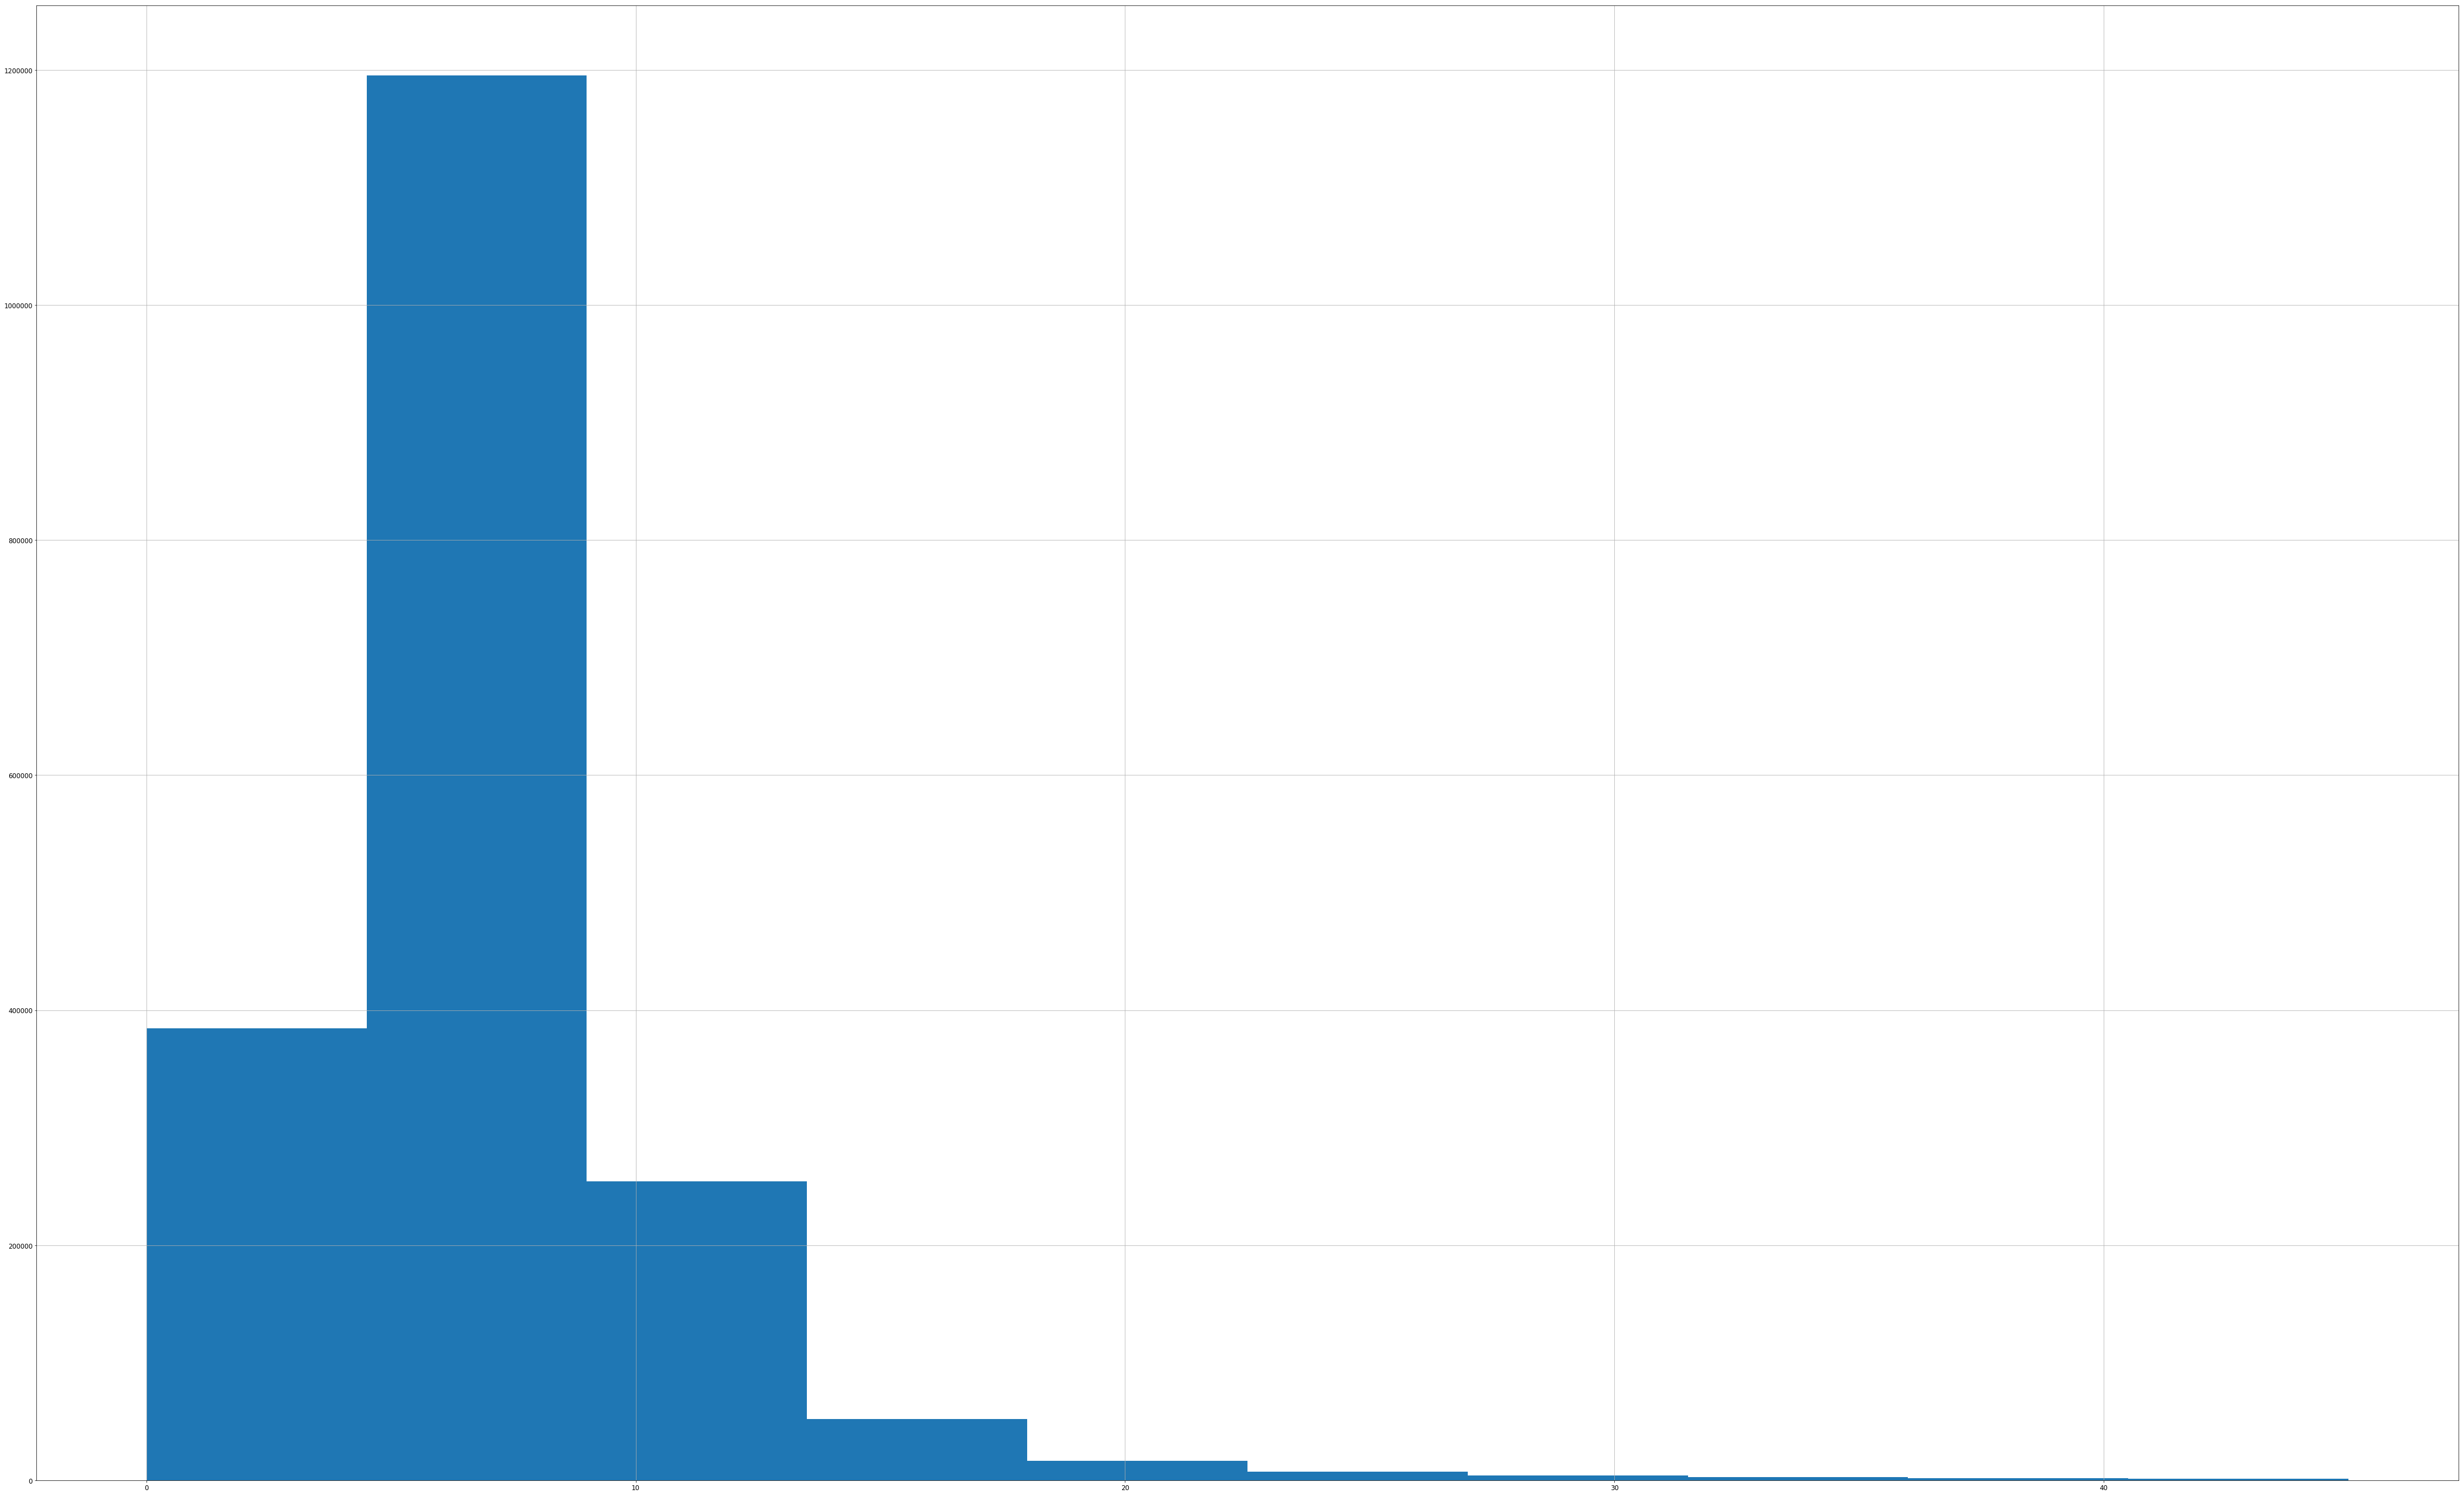

In [63]:
train = remove_sparse(train)
test = remove_sparse(test)
train = feature_engineering(train)
test = feature_engineering(test)
y_train = train.fare_amount
X_train = train.drop('fare_amount', axis=1)
y_test = test.fare_amount
X_test = test.drop('fare_amount', axis=1)

In [64]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,dayofweek,dayofyear,hourofday,distance,to_jfk,to_laguardia,to_newark
0,-73.844311,40.721319,-73.841610,40.712278,1,2009,0,166,13,0.639764,5.641042,3.960033,17.501190
1,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,11,5.246511,13.128071,5.651922,8.479163
2,-73.982738,40.761270,-73.991242,40.750562,2,2011,2,229,20,0.863167,13.205934,5.886113,10.521077
3,-73.987130,40.733143,-73.991567,40.758092,1,2012,5,112,0,1.737223,12.390673,6.379848,10.309372
4,-73.968095,40.768008,-73.956655,40.783762,1,2010,1,68,2,1.241710,12.972516,4.486914,12.130230


In [65]:
X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,dayofweek,dayofyear,hourofday,distance,to_jfk,to_laguardia,to_newark
0,-73.955140,40.779382,-73.914775,40.820602,2,2010,5,16,10,3.545447,13.018637,3.881634,13.093870
1,-73.998130,40.740360,-74.004150,40.733418,2,2010,2,48,23,0.573840,13.139567,7.032753,9.463861
2,-74.002960,40.739107,-73.990593,40.746082,2,2012,3,145,11,0.808024,13.008234,6.531418,9.654219
3,-73.985075,40.754526,-74.007655,40.746556,1,2013,1,239,6,1.306309,13.094860,6.096775,9.621335
4,-73.991698,40.759568,-73.996223,40.753263,5,2012,5,322,8,0.495634,13.526801,6.369029,10.359148


### XGBoost

In [66]:
# XGBoost
xgboost = Train(XGBRegressor(n_estimators=3,
                        max_depth = 9,
                        boosting_type = 'gbdt',
                        learning_rate = 0.05,
                        subsample = 0.85,
                        colsample_bytree = 0.8,
                        reg_alpha = 1e-4,
                        silent = True,
                        n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [67]:
# LightGBM
lgb = Train(LGBMRegressor(n_estimators=3,
                    max_depth = 9,
                    boosting_type = 'gbdt',
                    learning_rate = 0.05,
                    subsample = 0.85,
                    colsample_bytree = 0.8,
                    reg_alpha = 1e-4,
                    silent = True,
                    n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [68]:
# Catboost
cat = Train(CatBoostRegressor(n_estimators=3,
                        max_depth = 9,
                        loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        boosting_type = 'Plain',
                        bootstrap_type = 'Bernoulli',
                        learning_rate = 0.05,
                        subsample = 0.85,
                        silent = True), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00


## B. The Results

In [69]:
models = [('XGBoost', xgboost),
         ('LightGBM', lgb),
         ('CatBoost', cat)]

### R2 Scores

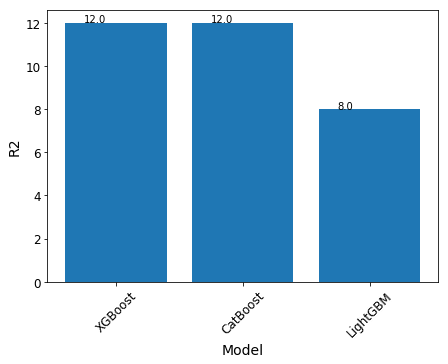

In [70]:
scores = [round(score) for score in scores]
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'R2': scores })
model_scores.sort_values(by='R2',ascending=False,inplace=True)
plot_metric(model_scores, score='R2')

### Training and Prediction Times

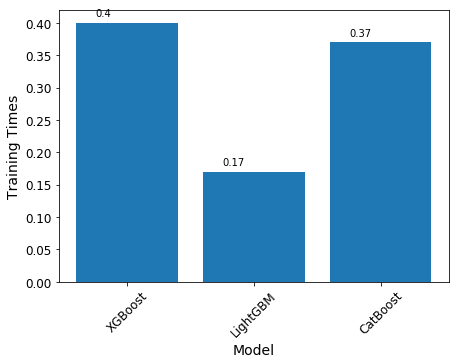

In [71]:
training_times = [round(time,2) for time in training_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Training Times': training_times })
plot_metric(model_train_times, score='Training Times')

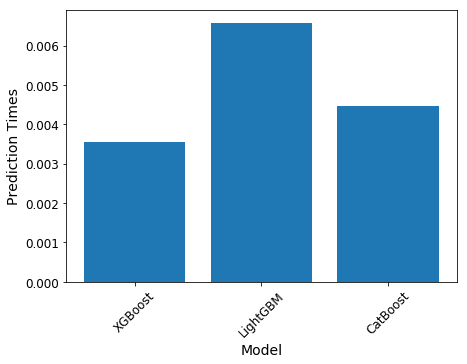

In [72]:
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Prediction Times': prediction_times })
plot_metric(model_train_times, score='Prediction Times')

### Feature Importances

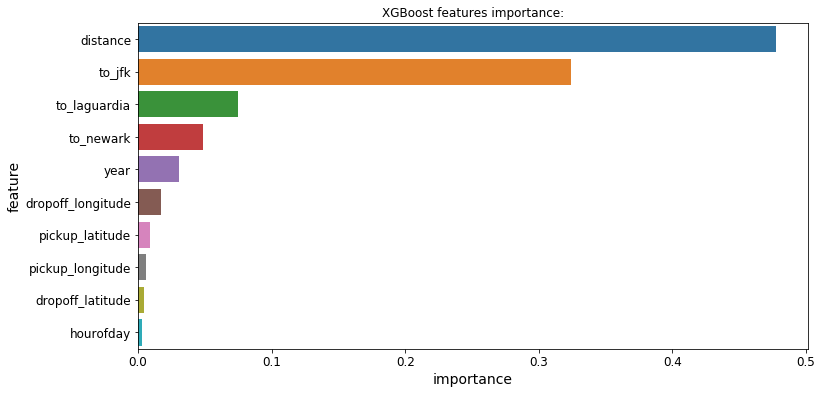

In [73]:
# XGBoost
feature_importances(X_train, xgboost, 'XGBoost')

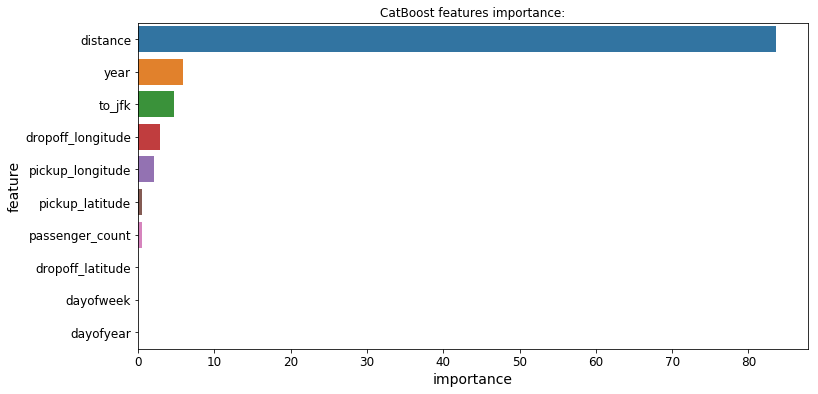

In [74]:
# CatBoost
feature_importances(X_train, cat, 'CatBoost')

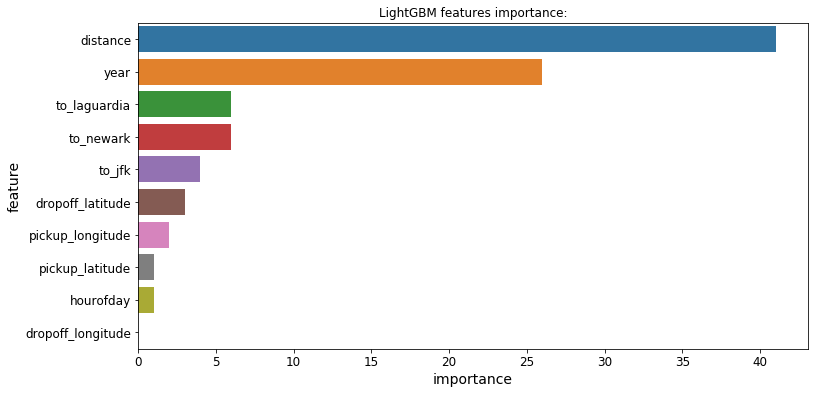

In [75]:
# LightGBM
feature_importances(X_train, lgb, 'LightGBM')

#### SHAP Values

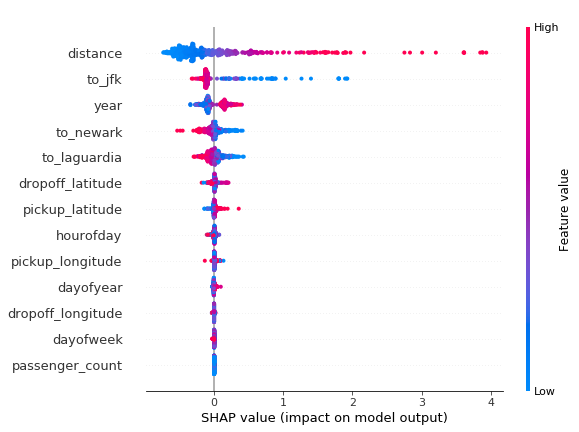

In [76]:
# XGBoost
shap_values(X_train.iloc[:500,:], xgboost, 'XGBoost')

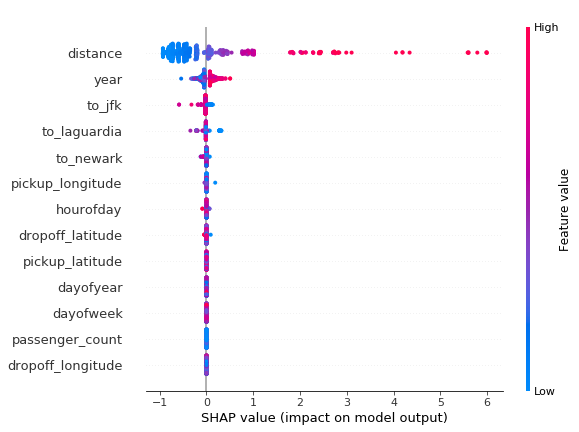

In [77]:
# LightGBM
shap_values(X_train.iloc[:500,:], lgb, 'LightGBM')

**CatBoost**
CatBoost doesn't work out of the box with shap_values() and results in the kernel crashing.

#### Visualize Trees

In [78]:
# Set figure size for decision tree plots
rcParams['figure.figsize'] = 80,50

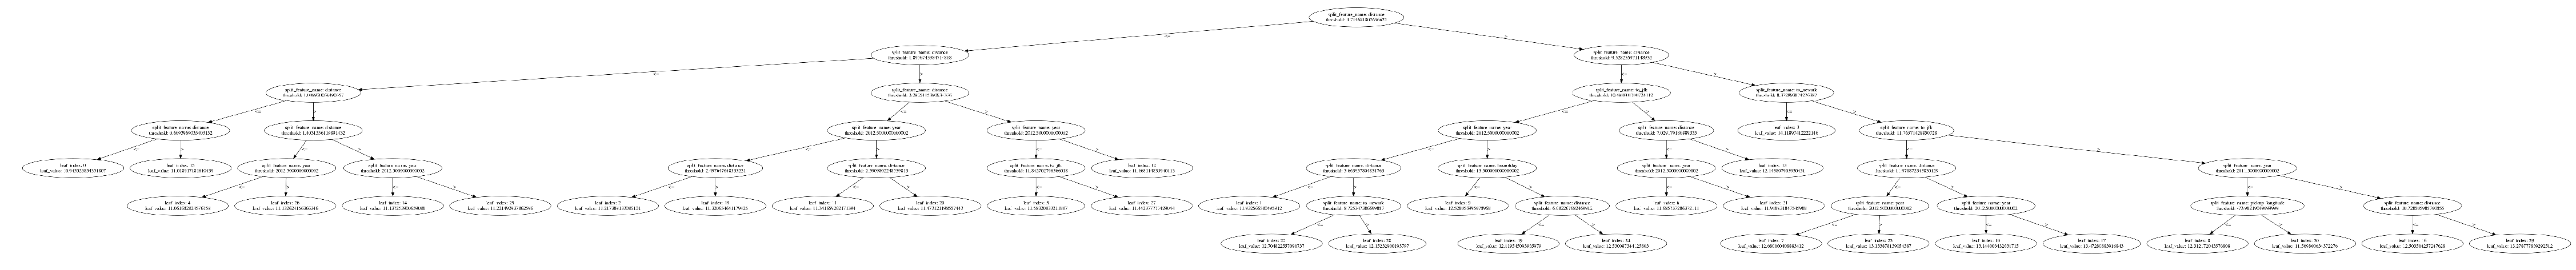

In [79]:
# LightGBM
lightgbm.plot_tree(lgb);

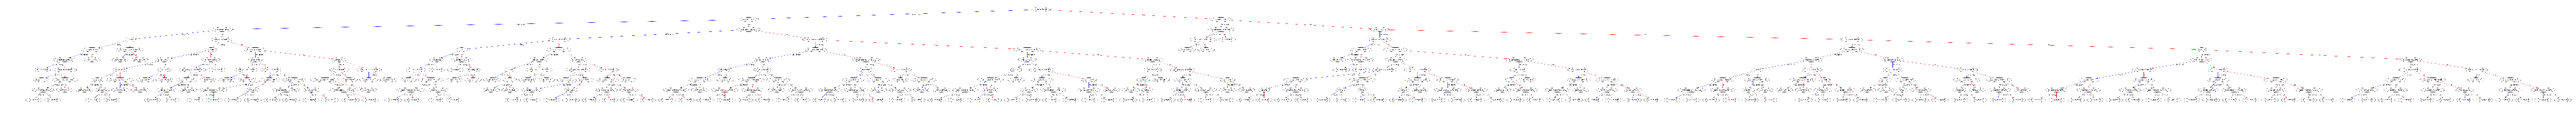

In [80]:
# XGBoost
xgb.plot_tree(xgboost);

**CatBoost**

CatBoost ships with no plotting function for its trees. If you really need to visualize CatBoost results, a work-around is proposed here: https://blog.csdn.net/l_xzmy/article/details/81532281

In [81]:
# Clear memory before moving onto the next round
import gc
gc.collect()

34654

# The Analysis

I hope you find this analysis useful! I encourage you to fork this kernel, and play with the code.

A detailed analysis of the results obtained in this kernel can be found on my blog at: https://lavanya.ai/2019/06/27/battle-of-the-boosting-algorithms/

If you like this kernel, please give it an upvote. Thank you!